# Model Compression 

We will try Pruning and Quantization on the trained Model

In [7]:
import torch

from transformers import (AutoModelForSequenceClassification, AutoTokenizer,TextClassificationPipeline)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [11]:
from pathlib import Path
from time import perf_counter
import numpy as np

from datasets import load_metric
accuracy_score = load_metric('accuracy')

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pipeline(example["text"])[0]["label"].split('_')[1]
            label = example["labels"]
            # preds.append(intents.str2int(pred))
            preds.append(pred)
            labels.append(label)
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_pipeline(self,query="What is the pin number for my account?"):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.pipeline(query)
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {self.optim_type: self.compute_size()}
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    plt.xlim(5, 53)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()


In [13]:
from datasets import load_dataset
clinc = load_dataset("clinc_oos","plus")
clinc.rename_column_('intent','labels')
clinc

Reusing dataset clinc_oos (C:\Users\Subha\.cache\huggingface\datasets\clinc_oos\plus\1.0.0\abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5500
    })
})

### _Default Model:_ DistilRoberta-Base

In [14]:
MODEL_DIR = './models/distilroberta-base/'
MODEL_NAME = 'distilroberta-base'

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model.to('cpu')
 
pipe = TextClassificationPipeline(model = model,tokenizer= tokenizer)


Model size (MB) - 313.75
Average latency (ms) - 20.49 +\- 2.89
Accuracy on test set - 0.886


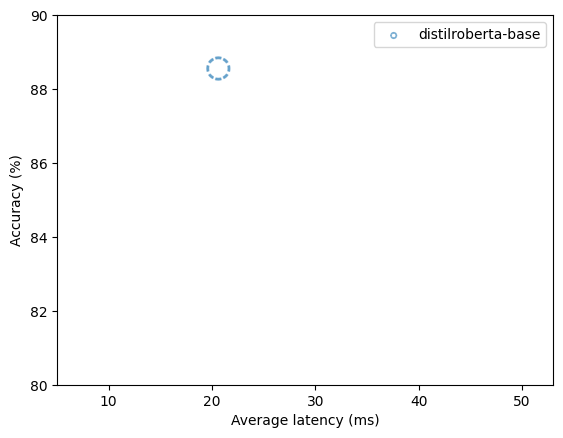

In [24]:
pb = PerformanceBenchmark(pipe, clinc["test"],optim_type=MODEL_NAME)
perf_metrics = pb.run_benchmark()
plot_metrics(perf_metrics,'distilroberta-base')

# Pruning

## Unstructured Pruning

In [25]:
from torch.nn.utils import prune 
pruner = prune.L1Unstructured(amount=0.1)
pr_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

state_dict = pr_model.state_dict()

for key in state_dict.keys(): 
    if "weight" in key: 
        state_dict[key] = pruner.prune(state_dict[key])

pr_model.load_state_dict(state_dict)

<All keys matched successfully>

Model size (MB) - 313.75
Average latency (ms) - 22.04 +\- 4.63
Accuracy on test set - 0.891


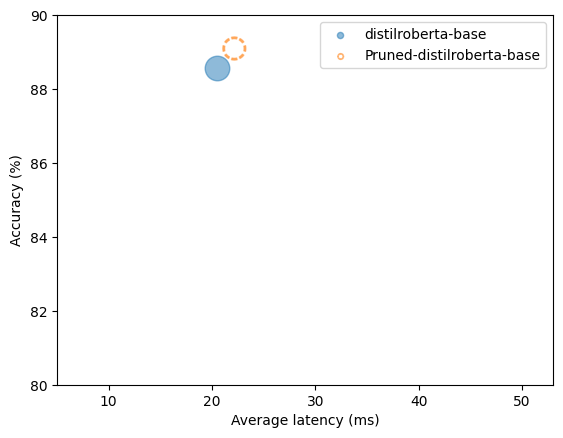

In [26]:
pruned_pipe = TextClassificationPipeline(model = pr_model,tokenizer= tokenizer)

pb = PerformanceBenchmark(pruned_pipe, clinc["test"],optim_type='Pruned-distilroberta-base')
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics,'Pruned-distilroberta-base')

# Quantization


## Quanitzation

In [32]:
import torch 


distilroberta_quan = torch.quantization.quantize_dynamic(
    model=model,
    qconfig_spec = {torch.nn.Linear: torch.quantization.default_dynamic_qconfig}, dtype=torch.qint8)

Model size (MB) - 190.25
Average latency (ms) - 13.72 +\- 2.34
Accuracy on test set - 0.886


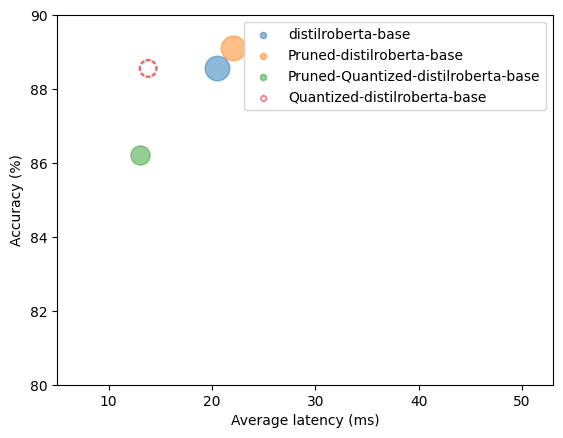

In [33]:
quantized_pipe = TextClassificationPipeline(model = distilroberta_quan,tokenizer= tokenizer)

pb = PerformanceBenchmark(quantized_pipe, clinc["test"],optim_type='Quantized-distilroberta-base')
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics,'Quantized-distilroberta-base')


## Pruning + Quantization

In [29]:

distilroberta_quan_pr = torch.quantization.quantize_dynamic(
    model=pr_model,
    qconfig_spec = {torch.nn.Linear: torch.quantization.default_dynamic_qconfig}, dtype=torch.qint8)

Model size (MB) - 190.25
Average latency (ms) - 13.03 +\- 1.95
Accuracy on test set - 0.862


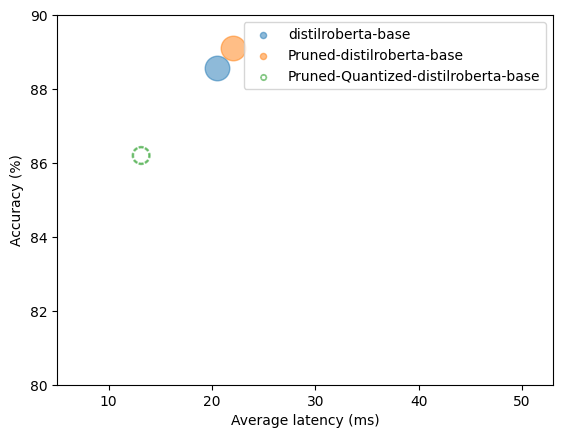

In [30]:
pruned_quantized_pipe = TextClassificationPipeline(model = distilroberta_quan_pr,tokenizer= tokenizer)

pb = PerformanceBenchmark(pruned_quantized_pipe, clinc["test"],optim_type='Pruned-Quantized-distilroberta-base')
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics,'Pruned-Quantized-distilroberta-base')